In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import lightgbm as lgb
from tqdm import tqdm_notebook
import joblib
import warnings
warnings.filterwarnings("ignore")

In [101]:
import numpy as np 
import pandas as pd
from pandas import Series,DataFrame

# 此处为清洗后，但未归一化的数据
df = pd.read_csv("Data.csv")
X = df.drop('RES', axis=1) # 数据集
y = df['RES'] # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train= np.column_stack((X_train,y_train))
test = np.column_stack((X_test, y_test))

print("test_transaction shape : ", train.shape)
print("test_identity shape : ", test.shape)

test_transaction shape :  (11200, 79)
test_identity shape :  (4800, 79)


In [102]:
X_train.describe()   #查看训练集信息

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号
count,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,...,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000
mean,1.859196,5.814464,7.837946,5.863373,2.092679,1.730545,36.834196,8.417232,6.266157,3942.608409,...,26.082946,0.854005,0.005496,0.039413,0.005521,0.081701,0.010707,0.145893,0.000625,0.256696
std,5.182627,0.701589,4.213675,3.381261,0.941156,0.718863,23.639128,5.183509,3.931509,2957.599603,...,12.281587,0.169638,0.012765,0.065812,0.033051,0.156211,0.056249,0.353015,0.024993,0.436830
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,5.000000,3.500000,1.000000,1.000000,22.000000,5.000000,3.666667,2413.987500,...,17.000000,0.845081,0.000003,0.001223,0.000000,0.015887,0.000000,0.000000,0.000000,0.000000
50%,0.000000,6.000000,7.000000,5.166667,2.000000,1.666667,32.000000,7.000000,5.333333,3120.565000,...,26.000000,0.907571,0.000570,0.016748,0.000000,0.027966,0.000000,0.000000,0.000000,0.000000
75%,0.000000,6.000000,10.000000,7.333333,3.000000,2.000000,46.000000,10.000000,7.833333,4473.460000,...,34.000000,0.946227,0.004843,0.049786,0.000000,0.051807,0.000000,0.000000,0.000000,1.000000
max,108.000000,7.000000,31.000000,30.000000,8.000000,7.000000,307.000000,75.000000,51.166667,44590.330000,...,70.000000,1.000000,0.429036,0.962401,1.000000,1.000000,0.857266,1.000000,1.000000,1.000000


In [103]:
# 统计数据中的NaN
X_train.isnull().sum()

一天去两家医院的天数    0
就诊的月数         0
月就诊天数_MAX     0
月就诊天数_AVG     0
月就诊医院数_MAX    0
             ..
治疗费用在总金额占比    0
个人支付治疗费用占比    0
BZ_民政救助       0
BZ_城乡优抚       0
是否挂号          0
Length: 78, dtype: int64

In [104]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11200 entries, 14741 to 7270
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   一天去两家医院的天数         11200 non-null  int64  
 1   就诊的月数              11200 non-null  int64  
 2   月就诊天数_MAX          11200 non-null  int64  
 3   月就诊天数_AVG          11200 non-null  float64
 4   月就诊医院数_MAX         11200 non-null  int64  
 5   月就诊医院数_AVG         11200 non-null  float64
 6   就诊次数_SUM           11200 non-null  int64  
 7   月就诊次数_MAX          11200 non-null  int64  
 8   月就诊次数_AVG          11200 non-null  float64
 9   月统筹金额_MAX          11200 non-null  float64
 10  月统筹金额_AVG          11200 non-null  float64
 11  月药品金额_MAX          11200 non-null  float64
 12  月药品金额_AVG          11200 non-null  float64
 13  医院_就诊天数_MAX        11200 non-null  int64  
 14  医院_就诊天数_AVG        11200 non-null  float64
 15  医院_统筹金_MAX         11200 non-null  float64
 16  医院_统筹金_AVG         11200

In [105]:
# 合并训练集，测试集
train = pd.merge(X_train, y_train, how="outer",left_index=True,right_index=True)
test = pd.merge(X_test, y_test, how="outer",left_index=True,right_index=True)

In [106]:
train.head()

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
14741,0,6,7,6.500000,2,2.000000,39,7,6.500000,2327.55,...,0.915357,0.006458,0.042342,0.0,0.020664,0.03928,0,0,1,0
11539,12,6,16,12.666667,4,3.333333,88,18,14.666667,7840.56,...,0.740529,0.000869,0.000000,0.0,0.248302,0.00000,1,0,0,0
14634,0,6,6,4.333333,1,1.000000,26,6,4.333333,4636.51,...,0.687355,0.000000,0.000000,0.0,0.312645,0.00000,0,0,1,0
11678,0,6,5,2.666667,1,1.000000,16,5,2.666667,8762.92,...,0.969552,0.000371,0.023155,0.0,0.006127,0.00000,1,0,0,0
12645,0,6,7,6.500000,2,1.666667,39,7,6.500000,2436.40,...,0.743346,0.000001,0.209257,0.0,0.015926,0.00000,0,0,0,0


In [107]:
test.head()

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
8756,6,6,17,13.166667,4,3.166667,85,20,14.166667,5325.45,...,0.950971,0.002488,0.016996,0.0,0.019346,0.0,0,0,0,0
4660,0,6,4,3.000000,2,1.666667,18,4,3.000000,3298.29,...,0.841222,0.000428,0.139756,0.0,0.013203,0.0,0,0,0,0
6095,0,6,5,4.333333,1,1.000000,26,5,4.333333,2310.10,...,0.964343,0.062396,0.028220,0.0,0.007277,0.0,0,0,1,0
304,0,6,8,5.833333,2,1.333333,35,8,5.833333,1765.66,...,0.897790,0.000927,0.003698,0.0,0.057939,0.0,0,0,0,0
8241,8,6,11,7.000000,3,2.666667,50,12,8.333333,7376.30,...,0.880859,0.003501,0.000000,0.0,0.119141,0.0,1,0,1,0


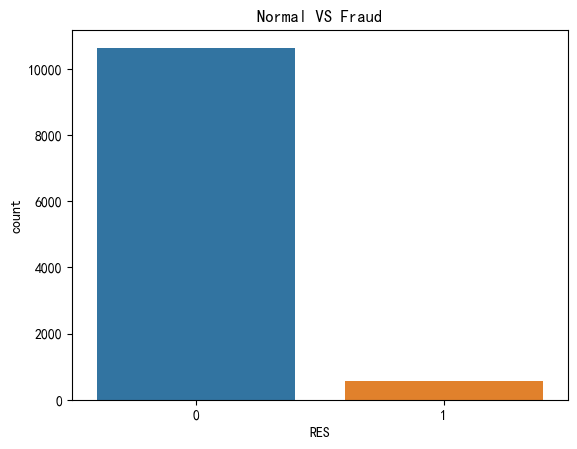

In [108]:
# 在train_transaction中，正负样本比例
sns.countplot(x="RES",data=train)
plt.title("Normal VS Fraud")
plt.show()

In [122]:
# params 超参数设置

params = {'num_leaves': 300, # 叶节点数量
          'min_data_in_leaf': 30, # 每个叶子节点中的数据
          'objective': 'binary', # 任务：二分类
          'max_depth': -1, # -1 ： 不限制深度
          "boosting_type": "gbdt", # 'dart', 'goss', 'rf'
          "metric": 'auc', # 衡量标准
          "verbosity" : -1, # 不显示信息
          'random_state': 66, # 随机种子
         }

In [123]:
# 创建DataFrame保存特征重要性
feature_importances = pd.DataFrame(index=None)

feature_importances['features'] = X_train.columns

In [124]:
feature_importances

,features
0,一天去两家医院的天数
1,就诊的月数
2,月就诊天数_MAX
3,月就诊天数_AVG
4,月就诊医院数_MAX
...,...
73,治疗费用在总金额占比
74,个人支付治疗费用占比
75,BZ_民政救助
76,BZ_城乡优抚


In [112]:
# 5折交叉验证
folds = KFold(n_splits=5)

splits = folds.split(X, y) # 分割成5份，前4份是训练集索引，最后1份是验证集索引

In [113]:
next(iter(splits)) # 输出的是索引

(array([ 3200,  3201,  3202, ..., 15997, 15998, 15999]),
 array([   0,    1,    2, ..., 3197, 3198, 3199]))

In [114]:
best_auc = 0
best_model = None
from lightgbm import log_evaluation, early_stopping

for k, (train_indices, val_indices) in enumerate(splits):
    print("第 %d 折\n" % k)
    X_train_data, X_val_data = X.iloc[train_indices], X.iloc[val_indices] # 训练集， 验证集
    y_train, y_val = y.iloc[train_indices], y.iloc[val_indices] # 训练标签，验证标签
    #print("X_train_data shape : \t", X_train_data.shape, "X_val_data shape : \t", X_val_data.shape)
    
    train_dataset = lgb.Dataset(X_train_data, label=y_train) # 训练集
    val_dataset = lgb.Dataset(X_val_data, label=y_val) # 验证集
    callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=30)] # 如果200轮后没有提升，就停止循环
    
    lgb_model = lgb.train(params=params, # 超参数设置
                          train_set=train_dataset, # 训练数据
                          num_boost_round=10000, # 循环的轮数
                          valid_sets=val_dataset, # 验证数据
                          valid_names='validation') 
    # 保存特征重要性
    feature_importances[f'fold_{k+1}'] = lgb_model.feature_importance()
    
    # 对验证集进行预测
    y_val_pred = lgb_model.predict(X_val_data)
    
    # 计算roc_auc
    roc_auc = roc_auc_score(y_val, y_val_pred)
    print(f" Fold {k + 1} | AUC_ROC ： { roc_auc * 100}%")


第 0 折

 Fold 1 | AUC_ROC ： 92.8599021960442%
第 1 折

 Fold 2 | AUC_ROC ： 92.94830757910229%
第 2 折

 Fold 3 | AUC_ROC ： 90.36643902439025%
第 3 折

 Fold 4 | AUC_ROC ： 91.02314919239376%


In [115]:
    # 判断是否是最优模型
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = lgb_model

In [116]:
feature_importances.shape

(78, 5)

In [117]:
feature_importances.head()

,features,fold_1,fold_2,fold_3,fold_4
0,一天去两家医院的天数,370,356,378,358
1,就诊的月数,248,275,258,281
2,月就诊天数_MAX,1076,1116,966,1074
3,月就诊天数_AVG,1577,1464,1401,1398
4,月就诊医院数_MAX,226,164,162,203


In [118]:
feature_importances['average'] = feature_importances[[f'fold_{k+1}' for k in range(folds.n_splits-1)]].mean(axis=1)

In [119]:
feature_importances.head()

,features,fold_1,fold_2,fold_3,fold_4,average
0,一天去两家医院的天数,370,356,378,358,365.50
1,就诊的月数,248,275,258,281,265.50
2,月就诊天数_MAX,1076,1116,966,1074,1058.00
3,月就诊天数_AVG,1577,1464,1401,1398,1460.00
4,月就诊医院数_MAX,226,164,162,203,188.75


Text(0.5, 1.0, '50 top features importance over 4 folds average.')

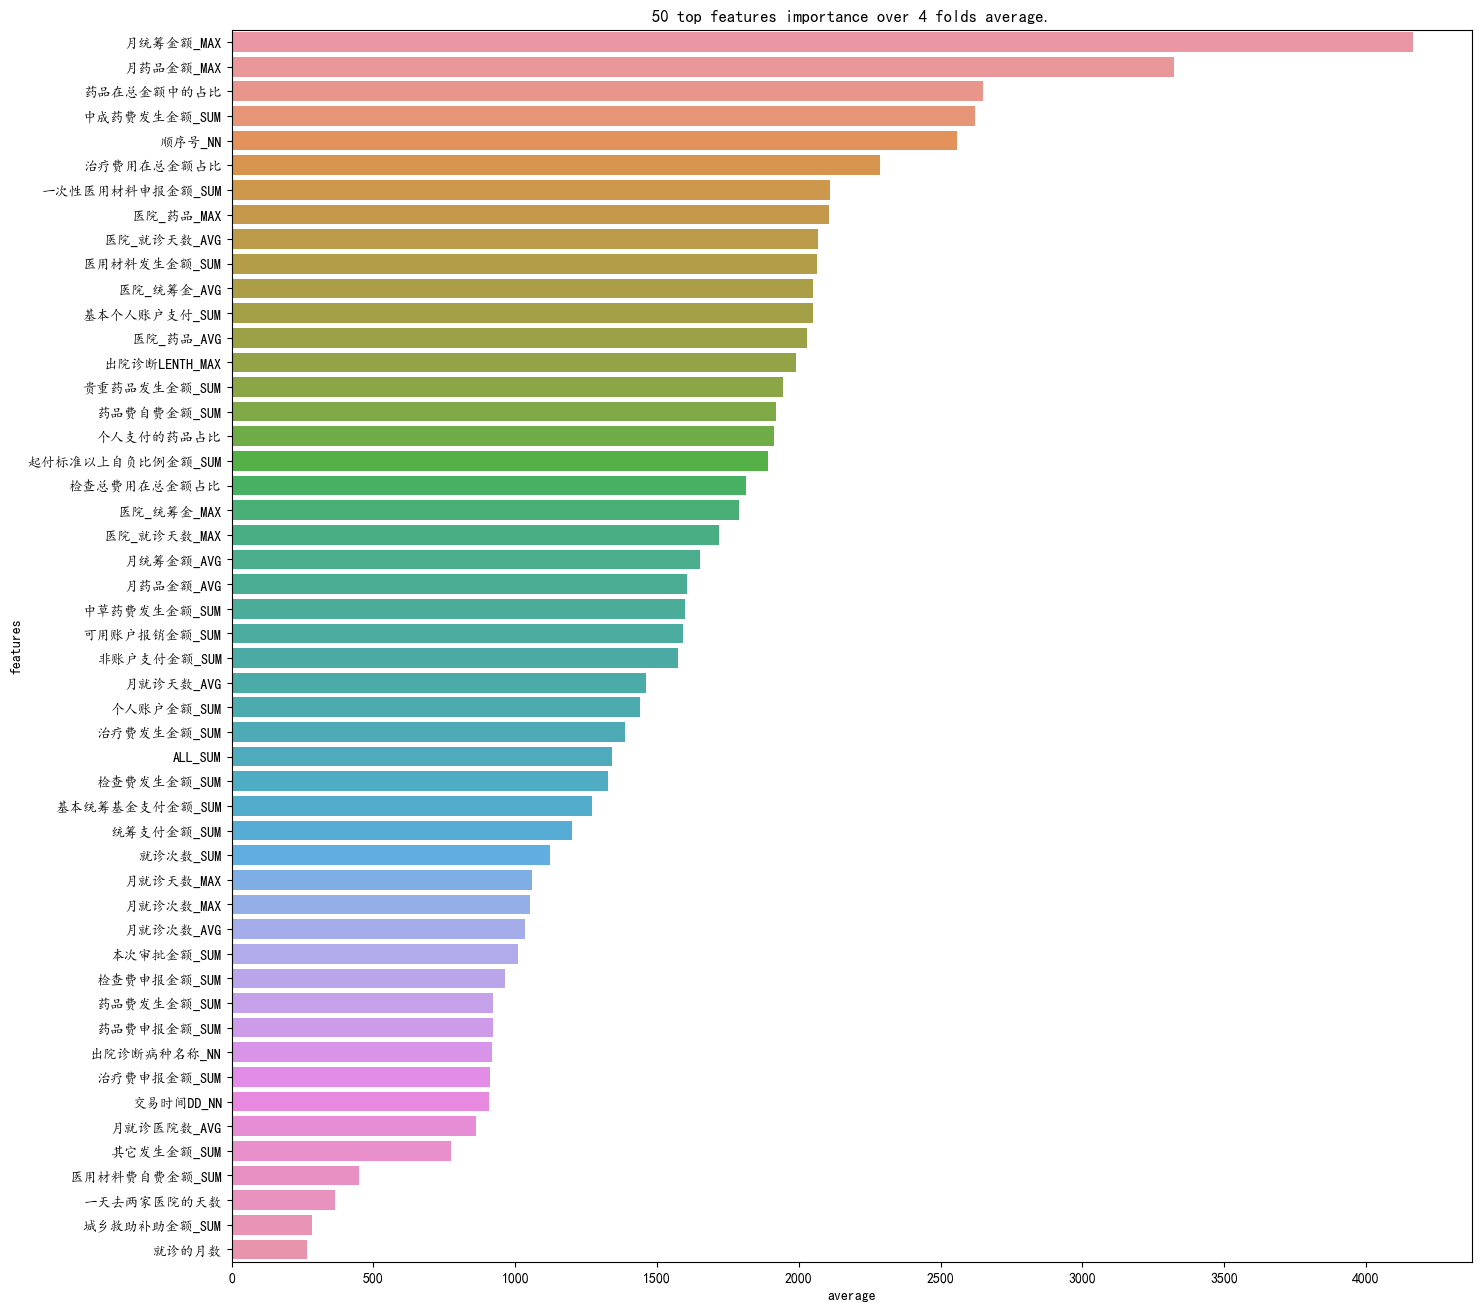

In [120]:
# 可视化显示前50个特征
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), 
            x='average', 
            y='features')
plt.title("50 top features importance over {} folds average.".format(folds.n_splits-1))

In [121]:
print("The best roc_auc : ", roc_auc)

The best roc_auc :  0.9102314919239376


In [30]:
joblib.dump(best_model, "best_model.pkl") # 保存模型

['best_model.pkl']

In [31]:
# 对与test进行预测

y_test_pred = best_model.predict(X_test)

In [32]:
y_test_pred.shape

(4800,)

In [33]:
labels = np.round(y_test_pred) # np.round() 四舍五入

In [34]:
from collections import Counter
Counter(labels)

Counter({0.0: 4594, 1.0: 206})

In [ ]:
# 导出最终结果

dd = pd.DataFrame(labels,columns=['Col1'])
dd.to_excel('./最终结果.xlsx')